In [2]:
!pip install -q xlrd
!pip install -q openpyxl

In [3]:
import numpy as np
import pandas as pd
import re, string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_excel('../input/learning/input_data-1.xlsx')

In [5]:
df

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,_x000D_\n_x000D_\nreceived from: hmjdrvpb.komu...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,_x000D_\n_x000D_\nreceived from: eylqgodm.ybqk...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8495,emails not coming in from zz mail,_x000D_\n_x000D_\nreceived from: avglmrts.vhqm...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


### missing values
in percentage

In [6]:
df.isna().mean()

Short description    0.000941
Description          0.000118
Caller               0.000000
Assignment group     0.000000
dtype: float64

counts

In [7]:
df.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [8]:
df = df.dropna().reset_index(drop=True)
df.shape

(8491, 4)

## label distribution

In [9]:
df['Assignment group'].nunique()

74

<AxesSubplot:ylabel='Assignment group'>

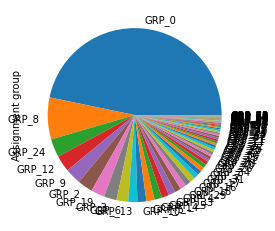

In [10]:
df['Assignment group'].value_counts().plot.pie()

#### 7 classes have only one example which makes it difficult to have a proper split between train and validation

In [11]:
label_dist = df['Assignment group'].value_counts().reset_index()
label_dist[label_dist['Assignment group'] == 1]

,index,Assignment group
68,GRP_61,1
69,GRP_73,1
70,GRP_64,1
71,GRP_67,1
72,GRP_35,1
73,GRP_70,1


## rare groups less tha 50 samples per class

<AxesSubplot:xlabel='index'>

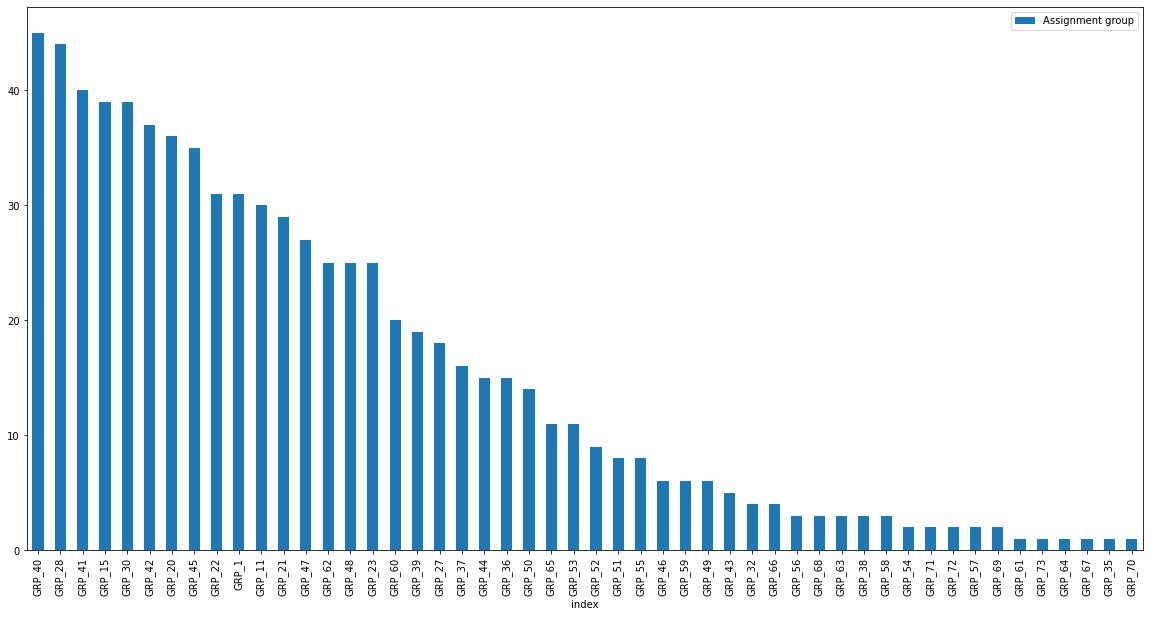

In [12]:
label_dist[label_dist['Assignment group'] <= 50].set_index('index').plot.bar(figsize=(20, 10))

## dropping classes with frequency one in the dataset

In [13]:
drop_classes = label_dist[label_dist['Assignment group'] == 1]['index'].values
df = df[~df['Assignment group'].isin(drop_classes)].reset_index(drop=True)

59 classes have example count less than 100

In [14]:
label_dist[label_dist['Assignment group'] <= 100].shape

(59, 2)

In [15]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

In [16]:
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(clean_text)
df['Description'] = df['Description'].apply(clean_numbers)
df['Description'] = df['Description'].str.strip()
df['Description'] = df['Description'].replace({ r'\A\s+|\s+\Z': '', '\n' : ' '}, regex=True)
df['Description'] = df['Description'].replace(r'_|-|-|–|―|−|―|—|─|¯', ' ', regex=True)
df['Description'] = df['Description'].replace(r'\b[b-x]\b', ' ', regex=True)
df['Description'] = df['Description'].replace(r'\\s+', r' ', regex=True)

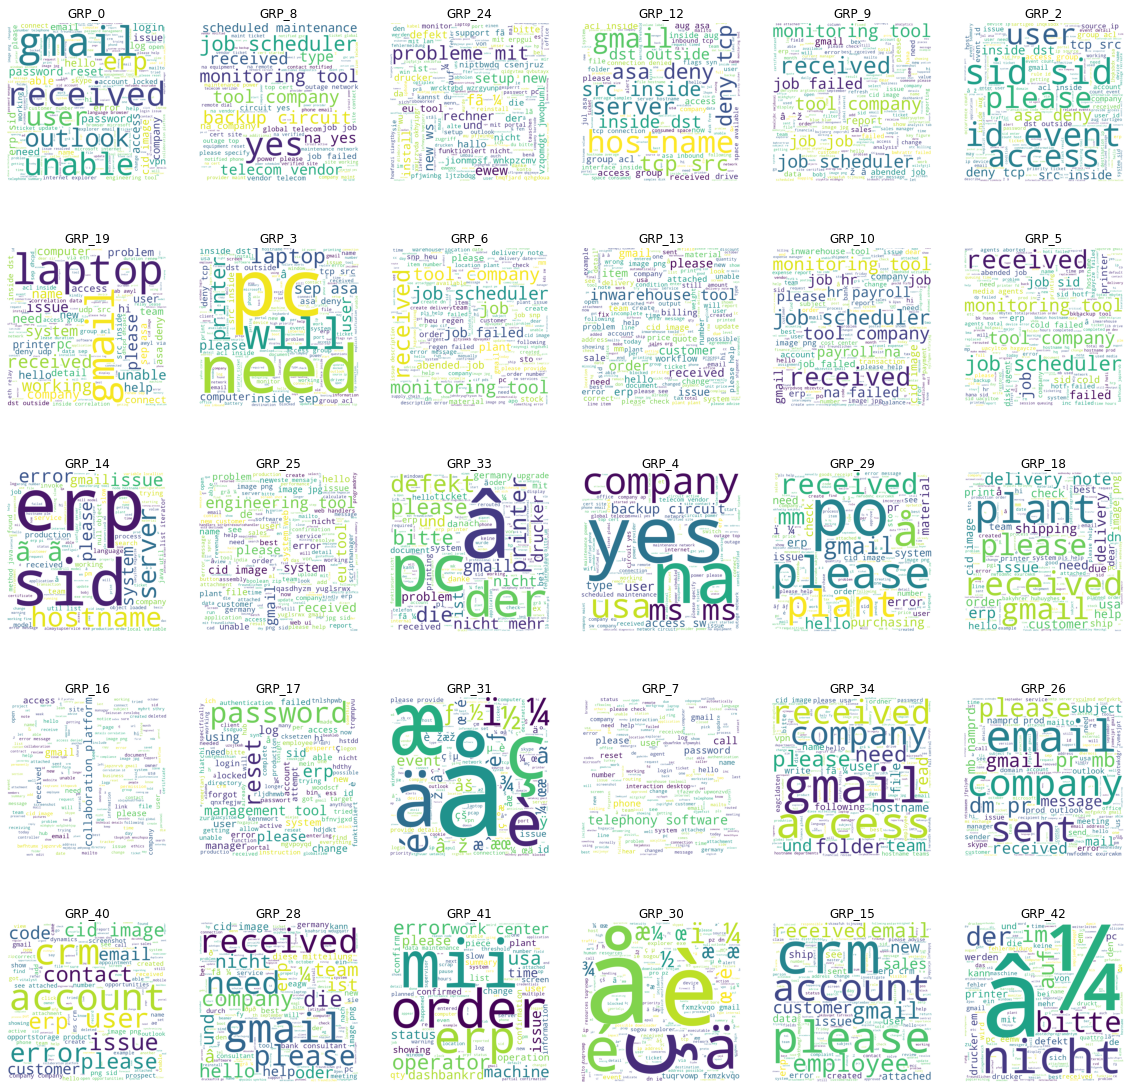

In [17]:
fig, axes = plt.subplots(5, 6, figsize=(20, 20))
fig.subplots_adjust(wspace=None, hspace=None)
stopwords = set(STOPWORDS)

for k, (ax, label) in enumerate(zip(axes.ravel(), df['Assignment group'].value_counts().index)):
    comb_sent = ' '.join(df.loc[df['Assignment group']==label, 'Description'])
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comb_sent)
    ax.set_title(label)
    ax.imshow(wordcloud)
    ax.axis('off')

### tokenization

In [18]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

In [19]:
tokenizer = Tokenizer(nlp.vocab)

In [20]:
df['Description'] = df['Description'].map(tokenizer).map(lambda x: ' '.join(x.text.split()))

In [21]:
df

,Short description,Description,Caller,Assignment group
0,login issue,verified user details . ( employee # & manager...,spxjnwir pjlcoqds,GRP_0
1,outlook,received from : hmjdrvpb . komuaywn @ gmail . ...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,received from : eylqgodm . ybqkwiam @ gmail . ...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
...,...,...,...,...
8480,emails not coming in from zz mail,received from : avglmrts . vhqmtiua @ gmail . ...,avglmrts vhqmtiua,GRP_29
8481,telephony_software issue,telephony software issue,rbozivdq gmlhrtvp,GRP_0
8482,vip2: windows password reset for tifpdchb pedx...,vip : windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8483,machine nÃ£o estÃ¡ funcionando,am unable to access the machine utilities to f...,ufawcgob aowhxjky,GRP_62


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [28]:
vocab = set(' '.join(df['Description']).split())

In [29]:
targ_enc = LabelEncoder()
targ = targ_enc.fit_transform(df['Assignment group'])

In [30]:
x_train, x_val, y_train, y_val = train_test_split(df['Description'], targ, random_state=2021, shuffle=True)

In [39]:
lr_pipe = make_pipeline(
                    TfidfVectorizer(decode_error='replace', max_features=5000),
                    LogisticRegression(solver='liblinear'))

In [40]:
lr_pipe.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(decode_error='replace', max_features=5000)),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [41]:
lr_pipe.score(x_val, y_val)

0.6366635249764373

In [44]:
lr_pipe = make_pipeline(CountVectorizer(vocabulary=vocab),
                       TfidfTransformer(), LogisticRegression(solver='liblinear'))

In [45]:
lr_pipe.fit(x_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(vocabulary={'!', '"', '#', '$', '%', '&', "'",
                                             '(', ')', '*', '+', ',', '.', '/',
                                             ':', ';', '<', '=', '>', '?', '@',
                                             '[', '\\', ']', '^', '`', 'a',
                                             'aa', 'aac', 'aad', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [46]:
lr_pipe.score(x_val, y_val)

0.6267672007540056